In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 1080,
        'scroll': True,
})

{'width': 1920, 'height': 1080, 'scroll': True}

# Week 11 (Monday), AST 8581 / PHYS 8581 / CSCI 8581 / STAT 8581: Big Data in Astrophysics

### Michael Coughlin <cough052@umn.edu>, Jie Ding <dingj@umn.edu>

With contributions totally ripped off from Ashley Villar (Harvard) and Vanessa Boehm (UC Berkeley and LBNL) 


# Where are we headed?

Foundations of Data and Probability -> Statistical frameworks (Frequentist vs Bayesian) -> Estimating underlying distributions -> Analysis of Time series (periodicity) -> Analysis of Time series (variability) -> Analysis of Time series (stochastic processes) -> Gaussian Processes -> Decision Trees / Regression -> Dimensionality Reduction  -> Principle Component Analysis -> Clustering / Density Estimation / Anomaly Detection -> Supervised Learning -> <b> Deep Learning </b> -> Introduction to Databases - SQL -> Introduction to Databases - NoSQL -> Introduction to Multiprocessing -> Introduction to GPUs -> Unit Testing

# Autoencoders

An autoencoder is a type of neural network which we will use to reduce the dimensionality of our data.

It is one example of a larger class of “representation learning” in deep learning.

An Auto-Encoder consists of two networks: 

1.   An encoder network that takes the data, $x$, and maps it to a lower-dimensional latent space. We will call this network $f$ and its network parameters $\phi$.
2.   A decoder network that takes the encoded data, $z$, and maps it back to the data space. We will call the result of the reconstruction $x'$, the decoder network $g$ (for generator) and its network parameters $\psi$.

$$ x' = g_\psi(f_\phi(x)) \tag{1}$$

An Auto-Encoder is trained to minimize the reconstruction error between the input $x$ and the reconstruction $x'$.

$$ \mathcal{L}_{AE}(\phi,\psi) = ||x-g_\psi(f_\phi(x))||^2_2 \tag{2}$$

<img src='figures/autoencoder.png' width=600>

## How to fit a model using MOO

- Model to fit the data (e.g. physics).
- Objective Function (or ‘loss/cost function’) which is a metric that you will choose to quantify how well the model fits the data (e.g. chi-squared).
- Optimization Method which you will use to find the best model (e.g. gradient descent).

# In-class warm-up: Training an autoencoder for galaxies

Let's lower the resolution of our images and only keep one filter. Plot an example of the lower resolution galaxies.

Next, flatten each image into a 1D array. Then rescale the flux of the images such that the mean is 0 and the standard deviation is 1. 

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

In [12]:
# Taken from https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

def to_categorical(y, num_classes=None, dtype="float32"):
    """Converts a class vector (integers) to binary class matrix.

    E.g. for use with `categorical_crossentropy`.

    Args:
        y: Array-like with class values to be converted into a matrix
            (integers from 0 to `num_classes - 1`).
        num_classes: Total number of classes. If `None`, this would be inferred
          as `max(y) + 1`.
        dtype: The data type expected by the input. Default: `'float32'`.

    Returns:
        A binary matrix representation of the input as a NumPy array. The class
        axis is placed last.

    Example:

    >>> a = tf.keras.utils.to_categorical([0, 1, 2, 3], num_classes=4)
    >>> print(a)
    [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]

    >>> b = tf.constant([.9, .04, .03, .03,
    ...                  .3, .45, .15, .13,
    ...                  .04, .01, .94, .05,
    ...                  .12, .21, .5, .17],
    ...                 shape=[4, 4])
    >>> loss = tf.keras.backend.categorical_crossentropy(a, b)
    >>> print(np.around(loss, 5))
    [0.10536 0.82807 0.1011  1.77196]

    >>> loss = tf.keras.backend.categorical_crossentropy(a, a)
    >>> print(np.around(loss, 5))
    [0. 0. 0. 0.]
    """
    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

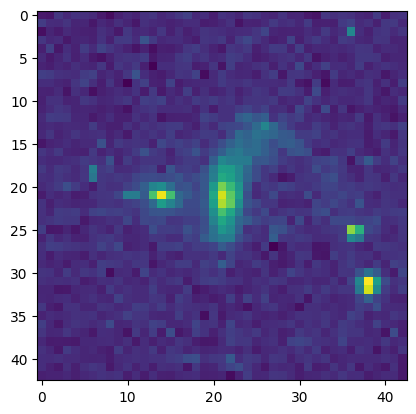

In [23]:
# https://www.astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5

# To get the images and labels from file
with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# To convert the labels to categorical 10 classes
labels = to_categorical(labels, 10)

labels = labels.astype(np.float32)
images = images.astype(np.float32)
images = torch.tensor(images)
labels = torch.tensor(labels)
images = images[:,::6,::6,1]

#Plot an example image here
plt.imshow(images[0])

#Flatten images here
images = images.reshape(len(images),-1)

#Normalize the flux of the images here
images = (images  - torch.mean(images))/torch.std(images)


### Split the training and test set with a 66/33 split.

In [24]:
images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.33, random_state=42)

## Understanding the Autoencoder

Below is sample of an autoencoder, built in Pytorch. Describe the code line-by-line at your table. Add another hidden layer before and after the encoded (latent) layer (this will be a total of 2 new layers). Choose the appropriate activation function for this regression problem. Make all of the activation functions the same.

In [14]:
class Autoencoder(torch.nn.Module):
      # this defines the model
        def __init__(self, input_size, hidden_size, hidden_inner, encoded_size):
            super(Autoencoder, self).__init__()
            print(input_size,hidden_size,encoded_size)
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.encoded_size = encoded_size
            self.hidden_inner = hidden_inner
            self.hiddenlayer1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.hiddenlayer2 = torch.nn.Linear(self.hidden_size, self.hidden_inner)
            self.encodedlayer = torch.nn.Linear(self.hidden_inner, self.encoded_size)
            self.hiddenlayer3 = torch.nn.Linear(self.encoded_size, self.hidden_inner)
            self.hiddenlayer4 = torch.nn.Linear(self.hidden_inner, self.hidden_size)
            self.outputlayer = torch.nn.Linear(self.hidden_size, self.input_size)
            # some nonlinear options
            self.sigmoid = torch.nn.Sigmoid()
            self.softmax = torch.nn.Softmax()
            self.relu = torch.nn.ReLU()
        def forward(self, x):
            layer1 = self.hiddenlayer1(x)
            activation1 = self.relu(layer1)
            layer2 = self.hiddenlayer2(activation1)
            activation2 = self.relu(layer2)
            layer3 = self.encodedlayer(activation2)
            activation3 = self.relu(layer3)
            layer4 = self.hiddenlayer3(activation3)
            activation4 = self.relu(layer4)
            layer5 = self.hiddenlayer4(activation4)
            activation5 = self.relu(layer5)
            layer6 = self.outputlayer(activation5)
            output = self.relu(layer6)
            return output, layer3

## Training

This is going to be a lot of guess-and-check. You've been warned. In this block, we will train the autoencoder. Add a plotting function into the training.

Note that instead of cross-entropy, we use the "mean-square-error" loss. Switch between SGD and Adam optimized. Which seems to work better? Optimize the `learning-rate` parameter and do *not* change other parameters, like momentum.

Write a piece of code to run train_model for 10 epochs. Play with the size of each hidden layer and encoded layer. When you feel you've found a reasonable learning rate, up this to 100 (or even 500 if you're patient) epochs. Hint: You want to find MSE~0.25.

In [15]:
# train the model
def train_model(training_data,test_data, model):
  # define the optimization
  criterion = torch.nn.MSELoss()

  # Choose between these two optimizers
  #optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.005,weight_decay=1e-6)

  for epoch in range(500):
    # clear the gradient
    optimizer.zero_grad()
    # compute the model output
    myoutput, encodings_train = model(training_data)
    # calculate loss
    loss = criterion(myoutput, training_data)
    # credit assignment
    loss.backward()
    # update model weights
    optimizer.step()
    print(epoch,loss)
    # STUDENTS ADD THIS PART
    output_test, encodings_test = model(test_data)
    loss_test = criterion(output_test, test_data)
    plt.plot(epoch,loss.detach().numpy(),'ko')
    plt.plot(epoch,loss_test.detach().numpy(),'ro')
  plt.show()  

1849 50 10
0 tensor(0.9998, grad_fn=<MseLossBackward0>)
1 tensor(0.9909, grad_fn=<MseLossBackward0>)
2 tensor(0.9676, grad_fn=<MseLossBackward0>)
3 tensor(0.9289, grad_fn=<MseLossBackward0>)
4 tensor(0.8867, grad_fn=<MseLossBackward0>)
5 tensor(0.8394, grad_fn=<MseLossBackward0>)
6 tensor(0.7947, grad_fn=<MseLossBackward0>)
7 tensor(0.7535, grad_fn=<MseLossBackward0>)
8 tensor(0.7188, grad_fn=<MseLossBackward0>)
9 tensor(0.6915, grad_fn=<MseLossBackward0>)
10 tensor(0.6739, grad_fn=<MseLossBackward0>)
11 tensor(0.6612, grad_fn=<MseLossBackward0>)
12 tensor(0.6486, grad_fn=<MseLossBackward0>)
13 tensor(0.6370, grad_fn=<MseLossBackward0>)
14 tensor(0.6267, grad_fn=<MseLossBackward0>)
15 tensor(0.6181, grad_fn=<MseLossBackward0>)
16 tensor(0.6091, grad_fn=<MseLossBackward0>)
17 tensor(0.6014, grad_fn=<MseLossBackward0>)
18 tensor(0.5949, grad_fn=<MseLossBackward0>)
19 tensor(0.5896, grad_fn=<MseLossBackward0>)
20 tensor(0.5843, grad_fn=<MseLossBackward0>)
21 tensor(0.5790, grad_fn=<MseLos

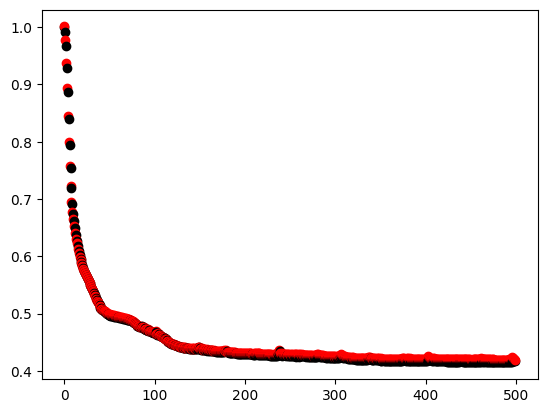

In [16]:

model = Autoencoder(np.shape(images_train[0])[0],50,50,10)
train_model(images_train, images_test, model)


### Understand our Results

Plot an image (remember you will need to reshape it to a 14x14 grid) with imshow, and plot the autoencoder output for the same galaxy. Try plotting the difference between the two. What does your algorithm do well reconstructing? Are there certain features which it fails to reproduce?

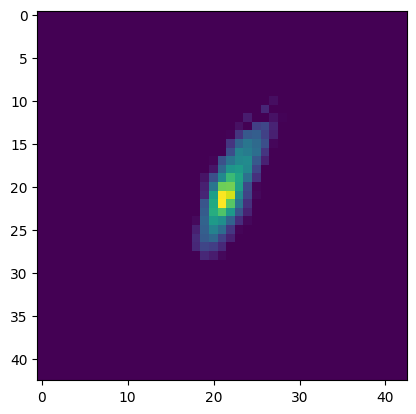

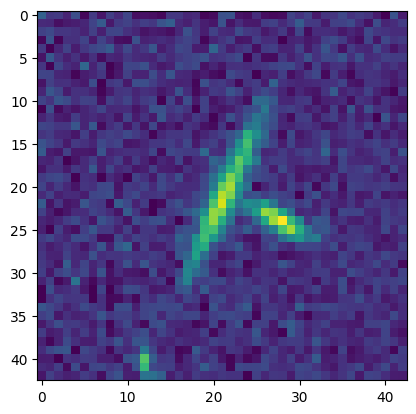

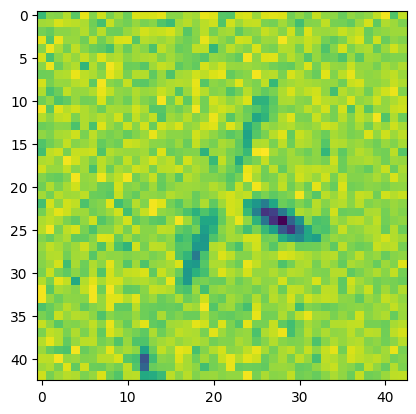

In [26]:
yhat, test_encodings = model(images_test)
yhat = yhat.detach().numpy()

yhat = np.reshape(yhat,(len(images_test),43,43))
image_reshaped = np.reshape(images_test,(len(images_test),43,43))
rand_int = int(np.random.choice(np.arange(len(yhat))))
plt.imshow(yhat[rand_int])
plt.show()

plt.imshow(image_reshaped[rand_int])
plt.show()

plt.imshow(yhat[rand_int] - image_reshaped[rand_int].detach().numpy())
plt.show()

### Latent Space 

Make a scatter plot of two of the 10 latent space dimensions. Do you notice any interesting correlations between different subsets of the latent space? Any interesting clustering?

Try color coding each point by the galaxy label using `plt.scatter`

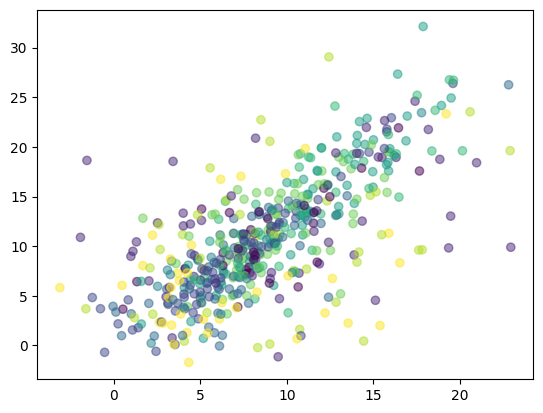

In [35]:
indices = np.argmax(labels_test, axis=1)

plt.scatter(test_encodings[0:500,1].detach().numpy(),
            test_encodings[0:500,3].detach().numpy(),
            c = indices[0:500],alpha=0.5)
plt.show()

### Playing with the Latent Space

Create a random forest classifier to classiy each galaxy using only your latent space.

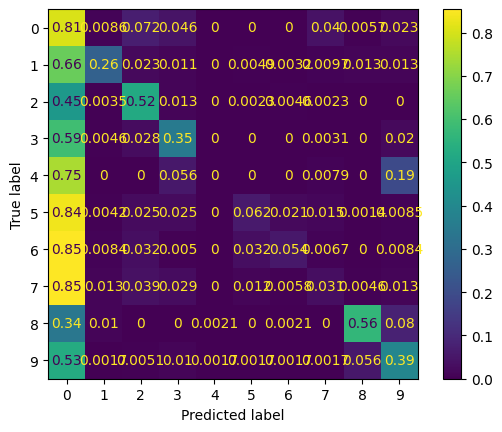

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
clf = RandomForestClassifier(max_depth=20, random_state=0)
yhat, train_encodings = model(images_train)

clf.fit(train_encodings.detach().numpy(), labels_train)
new_labels = clf.predict(test_encodings.detach().numpy())

new_indices = np.argmax(new_labels, axis=1)

cm = confusion_matrix(indices,new_indices,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Create an isolation forest to find the most anomalous galaxies. Made a cumulative distribution plot showing the anomaly scores of each class of galaxies. Which ones are the most anomalous? Why do you think that is?

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


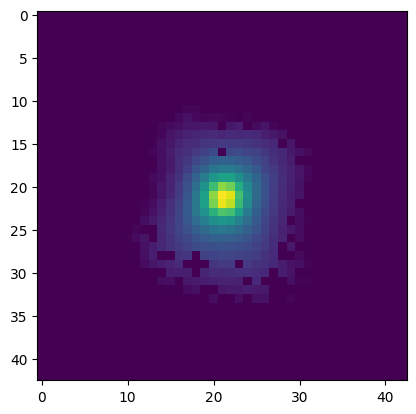

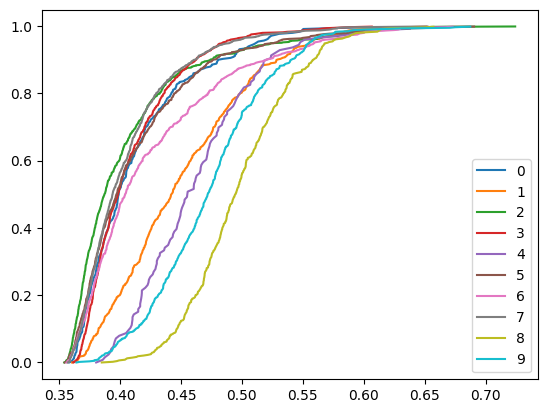

In [46]:

encodings = test_encodings.detach().numpy()
labels = labels_test.detach().numpy()
clf = IsolationForest(random_state=0,n_estimators=1000).fit(encodings)
scores = -clf.score_samples(encodings)
print(labels[np.argmax(scores)])
plt.imshow(yhat[np.argmax(scores)].detach().numpy().reshape(43,43))
plt.show()
plt.clf()
def cdf(x, label='',plot=True, *args, **kwargs):
    x, y = sorted(x), np.arange(len(x)) / len(x)
    return plt.plot(x, y, *args, **kwargs, label=label) if plot else (x, y)

ulabels = np.unique(indices)
for ulabel in ulabels:
  gind = np.where(indices==ulabel)
  cdf(scores[gind],label=str(ulabel))
plt.legend()
plt.show()

# Variational AutoEncoders (VAEs)


## Probabilistic Interpretation

**In a Variational Auto-Encoder we interpret the reconstruction task  probabilistically:**

Compressing the data results in a loss of information about the original data. 
If we only have access to the compressed data, we have no chance of knowing what the original data looked like *exactly*. Instead, we obtain a probability distribution over possible inputs.

This motivates a probabilistic formulation of the problem: 
Let's assume that the data follows some probabiliy distribution $p(x)$ (each data point is a drawn from this distribution)

$$ p(x) = \int \mathrm{d}z\, p(x|z) p(z) \tag{3}$$

Here, we have introduced two probability distributions on the right hand side, the liklelihood, $p(x|z)$, and the prior, $p(z)$.

The likelihood arises because of the information loss in the compression.

$$ x = g_\psi(f_\phi(x)) + \epsilon = g_\psi(z) + \epsilon \tag{4}$$ 

Ideally, $\epsilon$, the part of the data that is lost in the compression, is just noise and unimportant for our final data analysis. The form of the likelihood is equal to the distribution of this noise. For example, if the noise is Gaussian (which is often the case for physical data) with covariance $\Sigma_\epsilon$, the likelihood is a Gaussian distribution:

$$ p_{\psi}(x|z) = \mathcal{G}(g_\psi(z),\Sigma_\epsilon) \tag{5}$$ 

Starting from $p(x|z) = \int \mathrm{d}\epsilon\, p(x,\epsilon|z)$ can you show that the likelihood follows the same distribution as $\epsilon$?

$p(x|z) = \int \mathrm{d}\epsilon\, p(x,\epsilon|z) = \int \mathrm{d}\epsilon\, p(x|z,\epsilon) p(\epsilon) = \int \mathrm{d}\epsilon\, \delta_D(x-g(z)-\epsilon) p(\epsilon) = p(x-g(z))$ 

The prior, $p(z)$, is the average distribution of the encoded data.

$$ p(z) = \int \mathcal{d}x\, p(z|x) p(x) \tag{6}$$

In a VAE, we want the prior distribution to have closed form and to be easy to sample from (for artificial data generation). We have the freedom to choose the prior distribution as a constraint. The network training will ensure it is obeyed. A common choice is a normal distribution

$$ p(z) = \mathcal{N}(0,1) \tag{7} $$

### Variational Autoencoder & Evidence Lower BOund (ELBO)

To train the Variational Auto-Encoder we maximize the average log probability, $\log p(x)$, or, as we will see now, a lower bound to this quantity.

Equation (3) involves solving a fairly high dimensional integral, which is a computationally expensive and sometimes infeasible operation. This integral has to be solved not only once, but in each training step. Variational Autoencoders  solve this integral approximately by using a variational ansatz for the posterior distribution, the approximate posterior $q_\phi(z|x)$. This distribution approximates the true posterior p(z|x) and is parameterized by the encoder parameters $\phi$. 


The classic choice for the variational posterior is a multivariate Gaussian in the mean field approxiation (mean field meaning no off-diagonal terms in the covariance)

$$ q_\phi(z|x) = \mathcal{G}(\mu,\sigma_i) \tag{7} $$

where the mean, $\mu$, and variance, $\sigma$, are determined by the encoder network. 

$$(\mu, \sigma) = f_\phi(x) \tag{8} $$

The variational ansatz allows us to formulate a lower bound to $\log p(x)$, the Evidence Lower BOund.

$$ \log p(x) >= \int \mathrm{d}z\, q_\phi(z|x) \log{p_\psi(x|z)} - \int \mathrm{d}z\, q_\phi(z|x) \log{\frac{q_\phi(z|x)}{p(z)}} = ELBO \tag{8}$$

$$ \mathcal{L}_{VAE}(\phi,\psi) = -ELBO \tag{9}$$

The ELBO consists of two terms. The first term measures the expectation value of the likelihood over the posterior. Maximizing this term encourages high quality reconstructions (similar to the autoencoder). The second term is the KL-Divergence (a distance measure) between the variational posterior and the prior. This term acts as a regularizer. It encourages posterior distributions which are similar to the prior.

In VAE training the first term is evaluated stochastically, meaning that the expectation value is evaluated approximately by averaging over a number of samples from $q_\phi(z|x)$. The second term can be either evaluated analytically (the KL divergence between to Gaussian distributions can be calculated) or stochastically. 

### Reparametrization Trick

Minimizing Eq. (9) requires taking gradients with respect to $\phi$ and $\psi$. But how do we take the gradient through an expectation value?  

We use what is called the reparametrization trick. Instead of sampling from the posterior $q_\phi(z|x)$ we sample from the parameter-independent normal distribution

$$ \zeta ∼ \mathcal{N}(0,1) \tag{10}$$

and use the identity $z=\zeta*\sigma_\phi+\mu_\phi$, an operation which is trivially differentiably, to obtain our samples.

Pytorch will perform the reparametrization trick for us under the hood, if we use *distribution.rsample()* - so we don't have to code it explicitly.

Let' start by importing a few packages, that we will need later

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize

### Our dataset

In this coding exercise we will be working with a galaxy spectra sample from the SDSS-BOSS DR 16 release. The spectra have been de-redshifted to the restframe and their magnitude has been standardized to a distance correspondingg to $z_\lambda=0.1$. They have further been downsampled to 1000 pixels, denoised and inpainted where masks were present.

(I can tell you more about the data cuts and preprocessing if you are interested, but it is not relevant for this task.)

Despite being relatively high-dimensional ($d=1000$), galaxy spectra actually reside on a lower dimensional manifold. An indication for this is that we can compress them to much smaller dimensionality without sacrificing much reconstruction quality. 

This property makes them a very suitable data type for VAEs. 

(The same applies to image data, but images datasets are computationally more expensive to train on and they need more complicated nework architectures - things that we don't want to worry about in this exercise.)

STEP 1: Download the training and test datasets 

1.   [training set](https://drive.google.com/file/d/1oGe1zsgyCEBY1N_t-GkxxoSgVnJyTms2/view?usp=sharing)
2.   [test set](https://drive.google.com/file/d/1wXtOpUKGj2gMff2KbBfY4x8HnzxguyXJ/view?usp=sharing)


Let's set some immutable variables:
The dimensionality of the input data and the dimensionality of the latent (encoded) space

In [3]:
INPUT_SIZE      = 1000
LATENT_SIZE     = 6

Next we create pytorch datasets from the training and test data (note that you need to change the root_dir, if you placed the data in a different folder)

In [4]:
class SDSS_DR16(Dataset):
    """De-redshifted and downsampled spectra from SDSS-BOSS DR16"""

    def __init__(self, root_dir='drive/MyDrive/ML_lecture_data/', transform=True, train=True):
        """
        Args:
            root_dir (string): Directory of data file
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        if train:
            self.data = np.load(open('./DR16_denoised_inpainted_train.npy','rb'),allow_pickle=True)
        else:
            self.data = np.load(open('./DR16_denoised_inpainted_test.npy','rb'),allow_pickle=True)

        self.data = torch.as_tensor(self.data)
        self.mean = torch.mean(self.data)
        self.std  = torch.std(self.data)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = (self.data[idx]-self.mean)/self.std

        return sample


#initialize datasets
training_data = SDSS_DR16(train=True)
test_data     = SDSS_DR16(train=False)

##**Autoencoder**
This exercise starts with an Autoencoder, which is already implemented and working. The next cells walk you through the code. Your task (further below) will be to take that code and modify it into a Variational Autoencoder.

First, we define our encoder and decoder networks. We use a very simple MLP, with two linear layers and one non-linear activation function. 

In [5]:
# we inherit from pytorch Module class; https://pytorch.org/docs/stable/generated/torch.nn.Module.html

class Encoder(nn.Module):
    def __init__(self, seed=853):
        """
        seed: int, random seed for reproducibility
        """
        super(Encoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # here we are initializing the linear layers. This registeres the layer parameters (W,b) as parameters of the Module
        self.fc1 = nn.Linear(INPUT_SIZE,50)
        self.fc2 = nn.Linear(50,LATENT_SIZE)

    # this defines a forward pass of the network (="applying" the network to some input data)
    def forward(self, x):
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        z      = self.fc2(x)
        return z


class Decoder(nn.Module):
    def __init__(self, seed=620):
        """
        seed: int, random seed for reproducibility
        """
        super(Decoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(LATENT_SIZE,50)
        self.fc2 = nn.Linear(50,INPUT_SIZE)

    def forward(self, z):
        z = torch.nn.LeakyReLU()(self.fc1(z))
        x = self.fc2(z)
        return x

Having defined the encoder and decoder network, we can move on to define the Autoencoder.

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # here we are creating instances of the Encoder and Decoder class
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [7]:
# This creates an instance of the Autoencoder class
AE = Autoencoder()

The next step is to train the Autoencoder. This is what a generic training loop looks like:

In [8]:
# the training loop takes a function that loads the data batch by batch, a model to train, a loss function to train the model on and an optimizer
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    # iterate over the dataset
    for batch, X in enumerate(dataloader):
        # Compute prediction of the model (in case of the AE the prediction is the reconstructed data)
        pred = model(X)
        # Compute the loss function (in case of the AE this is the L2 distance to the input data)
        loss = loss_fn(pred,X)

        # Backpropagation; this is where we take the gradient and update the network parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # here we keep track of the loss
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return losses


# the test loop is similar to the training loop, only that we don't take any gradients/don't update the network parameters, but only evaluate
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss =  0
    with torch.no_grad():
        for X in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches
    print(f" Avg loss: {test_loss:>8f} \n")

    return test_loss

In the next cell we set the training parameters, define the loss function and create DataLoaders. Pytorch DataLoaders manage the data loading for us (break the dataset into batches, keep track of epochs, reshuffle the data after each epoch) 

In [9]:
BATCHSIZE       = 128
BATCHSIZE_TEST  = 256
LEARNING_RATE   = 1e-3

# MeanSquaredError (L2) Loss
loss_fn         = nn.MSELoss()
# Adam Optimizer
optimizer       = torch.optim.Adam(AE.parameters(), lr=LEARNING_RATE)

# Dataloaders
train_dataloader = DataLoader(training_data, batch_size=BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_data, batch_size=BATCHSIZE_TEST, shuffle=True)

It's finally time for training:

In [10]:
EPOCHS = 30
SEED   = 555  

train_loss = []
test_loss  = []
for t in range(EPOCHS):
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, AE, loss_fn, optimizer))
    test_loss.append(test_loop(test_dataloader, AE, loss_fn))
print("Done!")

Epoch 1
-------------------------------
loss: 0.662359  [    0/100000]
loss: 0.021159  [12800/100000]
loss: 0.033632  [25600/100000]
loss: 0.018294  [38400/100000]
loss: 0.006470  [51200/100000]
loss: 0.015909  [64000/100000]
loss: 0.009254  [76800/100000]
loss: 0.004984  [89600/100000]
 Avg loss: 0.007855 

Epoch 2
-------------------------------
loss: 0.004067  [    0/100000]
loss: 0.038032  [12800/100000]
loss: 0.006288  [25600/100000]
loss: 0.004543  [38400/100000]
loss: 0.005835  [51200/100000]
loss: 0.006564  [64000/100000]
loss: 0.004143  [76800/100000]
loss: 0.004086  [89600/100000]
 Avg loss: 0.006559 

Epoch 3
-------------------------------
loss: 0.003149  [    0/100000]
loss: 0.021008  [12800/100000]
loss: 0.005162  [25600/100000]
loss: 0.003507  [38400/100000]
loss: 0.005696  [51200/100000]
loss: 0.006305  [64000/100000]
loss: 0.003529  [76800/100000]
loss: 0.003757  [89600/100000]
 Avg loss: 0.005603 

Epoch 4
-------------------------------
loss: 0.002650  [    0/100000]

Let's see how the model is doing. Let's look at 

1.   Training and test loss 
2.   Final reconstruction quality

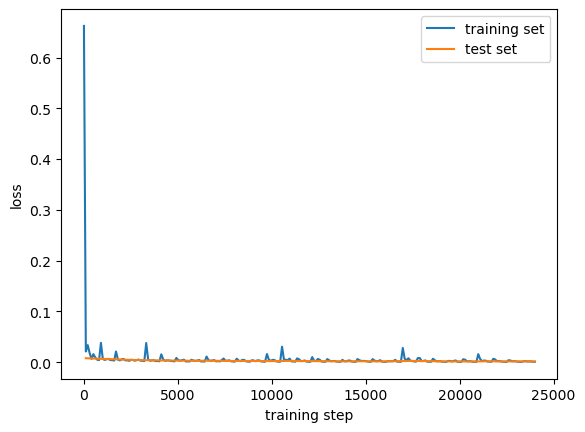

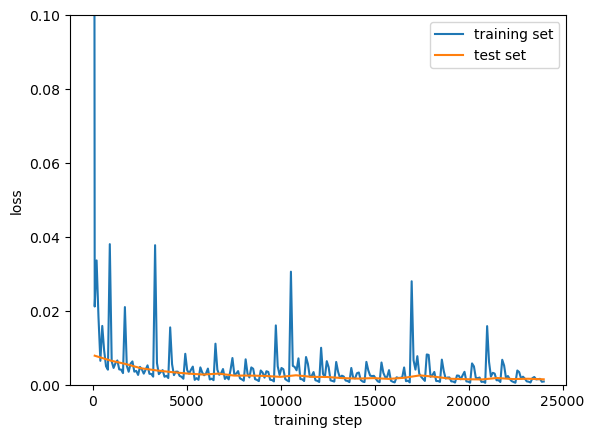

In [11]:
# losses
length = len(np.asarray(train_loss).flatten())
plt.figure()
plt.plot(np.linspace(0,length*100,length), np.asarray(train_loss).flatten(),label='training set')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss,label='test set')
plt.xlabel('training step')
plt.ylabel('loss')
plt.legend()
plt.show()

### zoom in 
length = len(np.asarray(train_loss).flatten())
plt.figure()
plt.plot(np.linspace(0,length*100,length), np.asarray(train_loss).flatten(),label='training set')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss,label='test set')
plt.xlabel('training step')
plt.ylabel('loss')
plt.legend()
plt.ylim(0,0.1)
plt.show()

You can see that the model had a really easy time learning the task and that we haven't overfitted yet

Now, let's look at a few reconstructions:

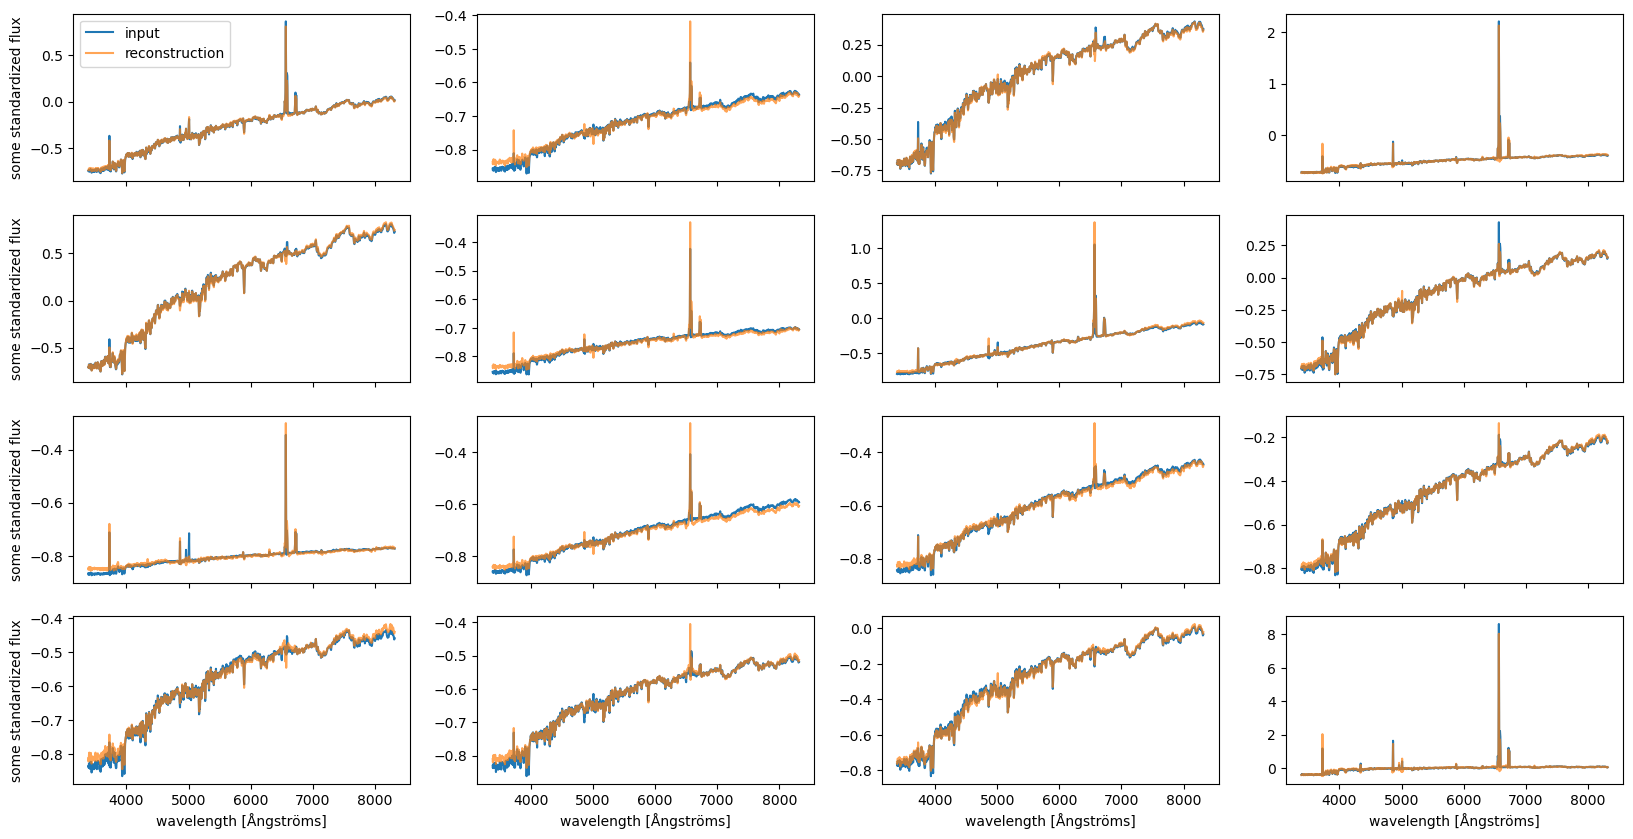

In [12]:
test_input = next(iter(test_dataloader))

with torch.no_grad():
  recons = AE(test_input)

# This is the mapping from pixel to the de-redshifted (rest) wavelength
wlmin, wlmax      = (3388,8318)
fixed_num_bins    = 1000
wl_range          = (np.log10(wlmin),np.log10(wlmax))
wl                = np.logspace(wl_range[0],wl_range[1],fixed_num_bins)

fig, ax = plt.subplots(4,4, figsize=(20,10), sharex=True)
ax = ax.flatten()
for ii in range(16):
  ax[ii].plot(wl,test_input[ii], label='input')
  ax[ii].plot(wl,recons[ii],alpha=0.7,label='reconstruction')
  if ii in np.arange(12,16):
    ax[ii].set_xlabel('wavelength [Ångströms]')
  if ii in [0,4,8,12]:
    ax[ii].set_ylabel('some standardized flux')
  if ii==0:
    ax[ii].legend()
plt.show()

... and the average reconstruction error as a function of wavelength:

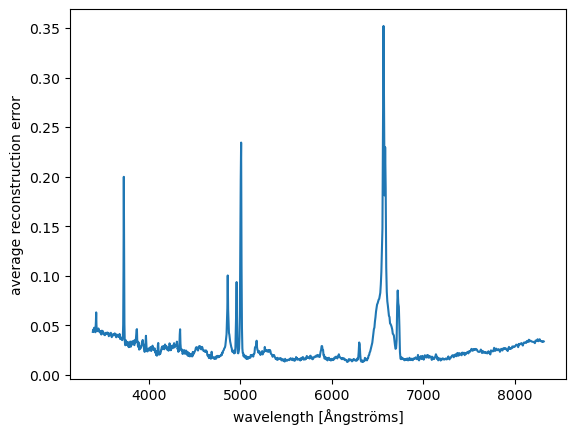

In [13]:
avg_loss  = 0
with torch.no_grad():
    for X in test_dataloader:
        pred = AE(X)
        avg_loss+=np.mean((pred.cpu().numpy()-X.cpu().numpy())**2,axis=0)/(len(test_data)//BATCHSIZE_TEST)

plt.figure()
plt.plot(wl,np.sqrt(avg_loss))
plt.ylabel('average reconstruction error')
plt.xlabel('wavelength [Ångströms]')
plt.show()

In [14]:
#Optional: save the model weights
#torch.save(AE.state_dict(), './AE_model_weights.pth')

A few things you might have noticed and that can be useful to keep in mind:


*   The model expects a single precision input. You can change the type of a tensor with tensor_name.type(), where tensor_name is the name of your tensor and type is the dtype. For typecasting into single precision floating points, use float(). A numpy array is typecasted with array_name.astype(type). For single precision, the type should be np.float32.
*   Before we analyze tensors we often want to convert them to numpy arrays with tensor_name.numpy()
*   If pytorch has been tracking operations that resulted in the current tensor value, you need to detach the tensor from the graph before you can transform it into a numpy array: tensor_name.detach(). Scalars can be detached with scalar.item()
*   If you tensor is currently on the GPU, you can bring it onto the CPU with tensor_name.cpu()

# **Variational Autoencoder**

Your task is to transform the above Autoencoder into a Variational Autoencoder.

We start by modifying the encoder network.

### **STEP 1:** Modify the encoder network.
The encoder network is used to characterize the variational distribution q(z|x). Recall that we want q(z|x) to be a Gaussian with diagonal covariance. An N-dimensional Gaussian with diagonal covariance is eqivalent to N independent 1-dimensional Gaussians (where N is the latent size). Each Gaussian is defined by two quantities, its mean and variance (or, if we take the sqrt, the standard deviation).

In [15]:
class VAEEncoder(nn.Module):

    def __init__(self, seed=853):
        super(VAEEncoder, self).__init__()
        # TASK: change the output size of the encoder network. How many parameters must it return to define q(z|x)?
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(INPUT_SIZE,50)
        self.fc2 = nn.Linear(50,LATENT_SIZE*2)

    def forward(self, x):
        # TASK: change the output of the encoder network. Instead of just returning z, it should return z and ...?
        # HINT: Don't forget that the standard deviation/variance must be strictly positive!
        # HINT: You might want to use torch.split(): https://pytorch.org/docs/stable/generated/torch.split.html
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        x      = self.fc2(x)
        mu,std = torch.split(x, LATENT_SIZE,dim=-1)
        std    = torch.exp(std) + 1e-8
        return mu, std


### **STEP 2:** Modify the decoder network.

We will leave our decoder network as it is :)

In [16]:
class VAEDecoder(nn.Module):

    def __init__(self, seed=620):
        super(VAEDecoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(LATENT_SIZE,50)
        self.fc2 = nn.Linear(50,INPUT_SIZE)

    def forward(self, z):
        z = torch.nn.LeakyReLU()(self.fc1(z))
        x = self.fc2(z)
        return x

Since we work with probability distributions in the VAE, we need to import the torch distributions package. We will only need the normal distribution for this exercise. 

In [17]:
#TASK: Familiarize yourself with torch.distribution.Normal - you can find the documentation here: https://pytorch.org/docs/stable/distributions.html#normal
#HINT: It takes a standard deviation (scale) not a variance as input
from torch.distributions import Normal as Normal 

### **STEP 3:** Modify the AE class into a VAE class!



1.   A VAE has a few more input parameters than an AE. We need a sample size, which determines how many samples we draw from $q_\phi(z|x)$ for evaluating the ELBO. We also need a $\sigma_\epsilon$ to characterize the likelihood, $p_\psi(x|z)=\mathcal{G}(x',\sigma_\epsilon)$.
2.   The prior is fixed. We can define it in the beginning, when we initialize the VAE.
3.   We need methods to compute the variational posterior, the likelihood, the KL-divergence and the ELBO.



In [18]:
class VariationalAutoencoder(nn.Module):
    #TASK: add parameters mentioned in point 1. 
    def __init__(self, sample_size, sigma):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VAEEncoder()
        self.decoder = VAEDecoder()
        self.sample_size = sample_size
        self.sigma       = sigma
        #TASK: Use the Normal class to define the prior (a standard normal distribution), p(z)
        self.prior       = Normal(torch.zeros(LATENT_SIZE), torch.ones(LATENT_SIZE))

    def change_sample_size(self,sample_size):
        self.sample_size = sample_size
        return True

    def get_q(self,x):
        #TASK: write a method that computes q(z,x)
        #HINT: use the Normal class we imported above
        mu, std = self.encoder(x)
        self.q = Normal(mu, std)
        return True

    def sample_q(self):
        #TASK: write a method that samples from q
        #HINT: use rsample to apply the reparameterization trick
        z_sample = self.q.rsample(torch.Size([self.sample_size]))
        return z_sample

    def get_avg_log_likelihood(self,recons,x):
        #TASK: Write a method that returns the first term in the ELBO (this method should define the likelihood and evaluate the average log likelihood of the reconstruction)
        #HINT: Pay attention to shapes. The function should return an average log likelihood (a single number) for every data point in the batch.
        #HINT: The output shape of Normal(mu, sigma).log_prob() is a little unintuitive. If mu or sigma are N-dimensional, it returns N results (applies N independent Gaussians). 
        #HINT: You need to average over samples from q to obtain the final result.
        ll    = Normal(x[None,:,:], self.sigma)
        log_p = ll.log_prob(recons)
        log_p = torch.sum(log_p,dim=-1)
        return torch.mean(log_p,dim=0)

    def stochastic_kl_divergence(self,z_sample):
        #TASK: Write a method that computes the kl-divergence between q(z|x) and p(z) 
        #HINT: Pay attention to shape
        return torch.mean(torch.sum(self.q.log_prob(z_sample),dim=-1)-torch.sum(self.prior.log_prob(z_sample),dim=-1), dim=0)

    def forward(self, x):
        #TASK: a forward pass should return the two terms in the ELBO
        #HINT: use all the methods we defined above
        self.get_q(x)
        samples = self.sample_q()
        recons  = self.decoder(samples)
        log_likelihood = self.get_avg_log_likelihood(recons,x)
        kl      = self.stochastic_kl_divergence(samples)
        return log_likelihood, kl

### **STEP 4**: Prepare for training

In [19]:
#TASK: create an instance of the Variational Autoencoder with sample_size=4 and sigma=1
VAE = VariationalAutoencoder(4,sigma=1)

optimizer = torch.optim.Adam(VAE.parameters(), lr=LEARNING_RATE)


#from torch.optim.lr_scheduler import StepLR
#scheduler = StepLR(optimizer, step_size=10, gamma=0.75)

In [20]:
#TASK: define the new loss function
def negative_ELBO(avg_log_likelihood,kl):

    negative_ELBO = - torch.mean(avg_log_likelihood-kl)

    return negative_ELBO

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    for batch, X in enumerate(dataloader):
        #TASK: compute the loss from the output of the VAE foward pass  
        log_likelihood, kl = model(X)
        loss = loss_fn(log_likelihood,kl)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    #scheduler.step()
    return losses


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, nllh, kl_ = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for X in dataloader:
            #TASK: in the test loop we want to keep track not only of the ELBO, but also of the two terms that contribute to the ELBO (kl diveregence and loglikelihood)
            log_likelihood, kl = model(X)
            test_loss += loss_fn(log_likelihood,kl).item()
            nllh += -np.mean(log_likelihood.cpu().numpy())
            kl_ += np.mean(kl.cpu().numpy())


    test_loss /= num_batches
    kl_ /= num_batches
    nllh /= num_batches

    print(f" Avg test loss      : {test_loss:>8f}")
    print(f" Avg KL             : {kl_:>8f}")
    print(f" Avg negative log likelihood : {nllh:>8f} \n")

    return test_loss, kl_, nllh


Let's train!    
**Note:** Training a VAE can be unstable. If things get weird, try changing the random seed or hyperparameters, such as the number of epochs, batchsize, learning rate, sample size, likelihood noise level...

**HINT:** To get good artificial data samples, you need to have a KL divergence in the single digits

In [22]:
EPOCHS = 8
SEED   = 123

train_loss = []
test_loss  = []
for t in range(EPOCHS):
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, VAE, negative_ELBO, optimizer))
    test_loss.append(test_loop(test_dataloader, VAE, negative_ELBO))
print("Done!")

Epoch 1
-------------------------------
loss: 1722.299683  [    0/100000]
loss: 50029.582031  [12800/100000]
loss: 22131.740234  [25600/100000]
loss: 7868.396484  [38400/100000]
loss: 5808.080078  [51200/100000]
loss: 4474.636230  [64000/100000]
loss: 4092.660400  [76800/100000]
loss: 4156.284180  [89600/100000]
 Avg test loss      : 4050.454234
 Avg KL             : 1687.292289
 Avg negative log likelihood : 2363.161942 

Epoch 2
-------------------------------
loss: 3945.382324  [    0/100000]
loss: 2913.567871  [12800/100000]
loss: 2933.194092  [25600/100000]
loss: 3157.218750  [38400/100000]
loss: 2752.395996  [51200/100000]
loss: 2559.265625  [64000/100000]
loss: 2495.079590  [76800/100000]
loss: 2576.175781  [89600/100000]
 Avg test loss      : 2604.173923
 Avg KL             : 801.958064
 Avg negative log likelihood : 1802.215876 

Epoch 3
-------------------------------
loss: 2619.602051  [    0/100000]
loss: 2224.551514  [12800/100000]
loss: 2251.279541  [25600/100000]
loss: 2

In [23]:
test_loss = np.asarray(test_loss)

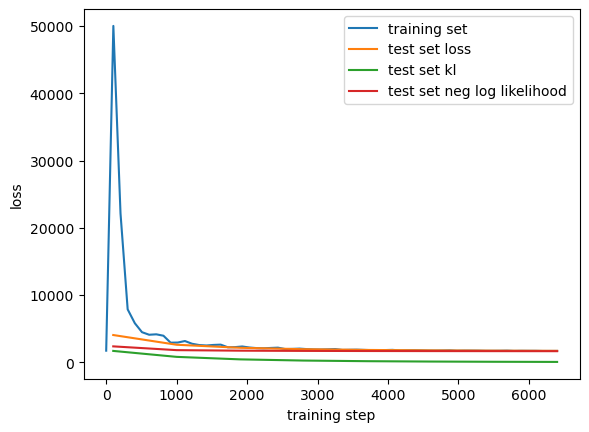

In [24]:
#TASK: plot the training loss, test loss, and the contributions to the loss from each of the two terms 
length = len(np.asarray(train_loss).flatten())
plt.figure()
plt.plot(np.linspace(0,length*100,length), np.asarray(train_loss).flatten(),label='training set')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss[:,0],label='test set loss')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss[:,1],label='test set kl')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss[:,2],label='test set neg log likelihood')
plt.xlabel('training step')
plt.ylabel('loss')
plt.legend()
plt.show()

## TASK: Inspect how the contribution of the kl divergence and log likelihood to the loss change as you change the noise in the likelihood. Some suggested values: sigma=[0.5,1,2]
## TASK: what happens when you change the number of samples?
### What do you observe? Can you interpret it?

### **STEP 5:** Inspect the model performance

Similar to the AE, we will look at the average reconstruction quality. But in addition, we also want to know how well the kl term was minimized. We will therefore look at three things

1.   Reconstruction quality
2.   Scatter plots of posterior samples and prior samples. Recall that $p(z)=\int \mathcal{d}x\, p(x,z) \approx \frac{1}{N_{samples}} \sum_{x\sim p(x)} p(z|x)$.
3.   Quality of artificial data generation


### TASK: plot the average reconstruction error of the model as a function of wavelength (similar to above). How does it compare to the Autoencoder?

Use the mean of $q(z|x)$ as the latent point for data x

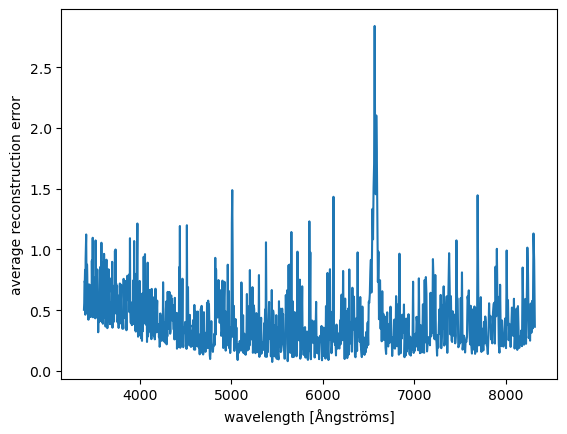

In [25]:
avg_loss  = 0
VAE.eval()
with torch.no_grad():
    for X in test_dataloader:
        pred = VAE.decoder(VAE.encoder(X)[0])
        avg_loss+=np.mean((pred.cpu().numpy()-X.cpu().numpy())**2,axis=0)/(len(test_data)//BATCHSIZE_TEST)

plt.figure()
plt.plot(### TASK: make a corner plot of posterior samples. Does the average posterior match the prior?

plt.ylabel('average reconstruction error')
plt.xlabel('wavelength [Ångströms]')
plt.show()

### TASK: make a corner plot of posterior samples. Does the average posterior match the prior?


(30000, 6)
(30208, 6)


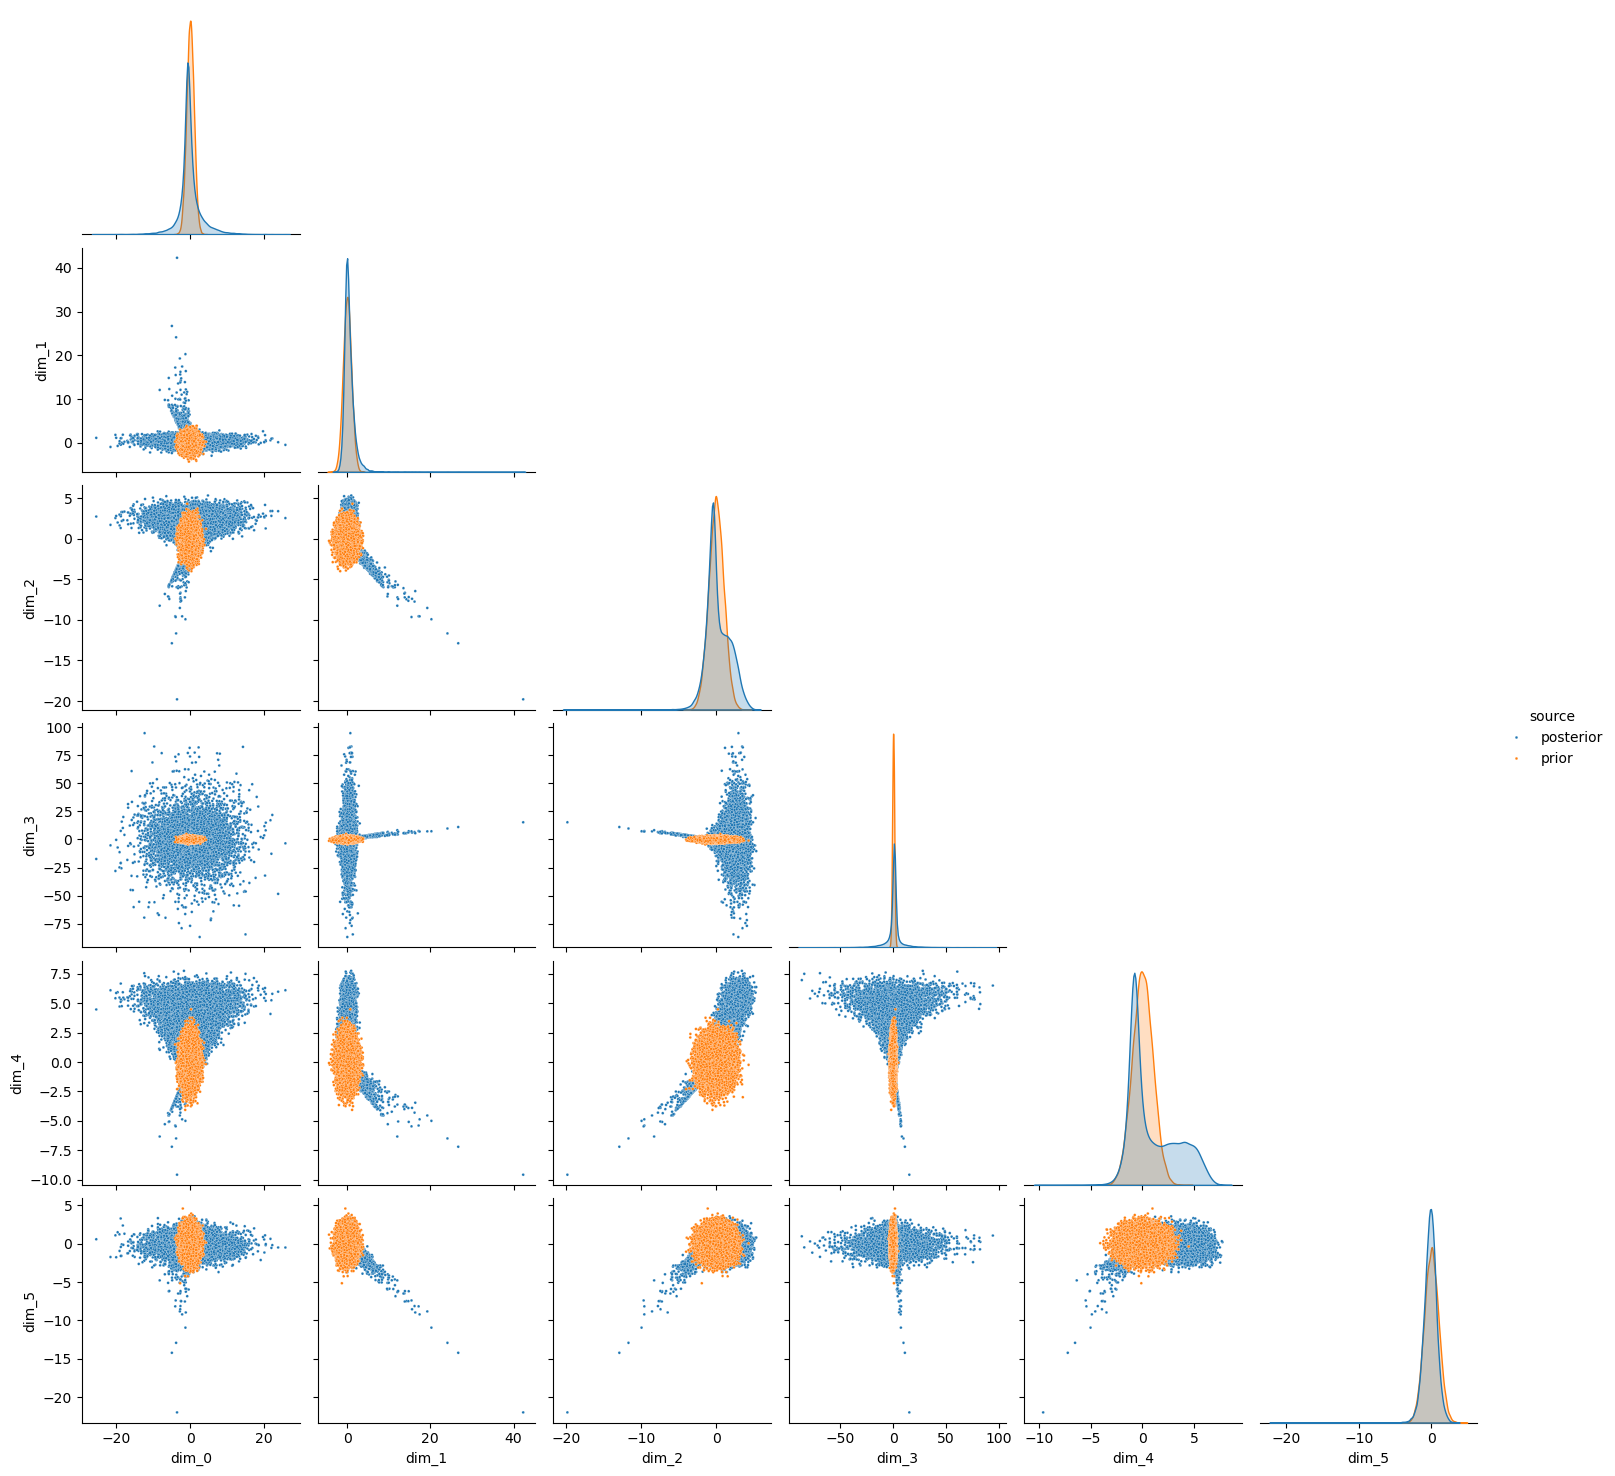

In [26]:
import seaborn as sns
import pandas as pd

VAE.eval()
with torch.no_grad():
    for ii, X in enumerate(test_dataloader):
        VAE.get_q(X)
        prior_sample = VAE.prior.sample([BATCHSIZE_TEST])
        sample       = VAE.sample_q().cpu().numpy()[0:1].swapaxes(0,1)
        if ii==0:
          samples       = sample
          prior_samples = prior_sample
        else:
          samples       = np.vstack([samples, sample])
          prior_samples = np.vstack([prior_samples, prior_sample])

samples       = np.reshape(samples,[-1, LATENT_SIZE])
prior_samples = np.reshape(prior_samples,[-1, LATENT_SIZE])

print(samples.shape)
print(prior_samples.shape)

data1    = pd.DataFrame()
data2    = pd.DataFrame()

for ii in range(LATENT_SIZE):
  data1['dim_%d'%ii] = samples[:,ii]
data1['source'] = 'posterior'

for ii in range(LATENT_SIZE):
  data2['dim_%d'%ii] = prior_samples[:,ii]
data2['source'] = 'prior'

data = pd.concat([data1,data2]).reset_index(drop=True)


#HINT: to get a density estimate you can set kind='kde', but you'll probably have to reduce the number of samples, KDE optimization scales pretty badly with number of samples
sns.pairplot(data,corner=True,kind='scatter', hue='source', plot_kws={'s':4})
plt.show()

## TASK: Generate artificial data: sample from the prior and foward model the sample thorugh the decoder. Do the samples look realistic? Why?/Why not?

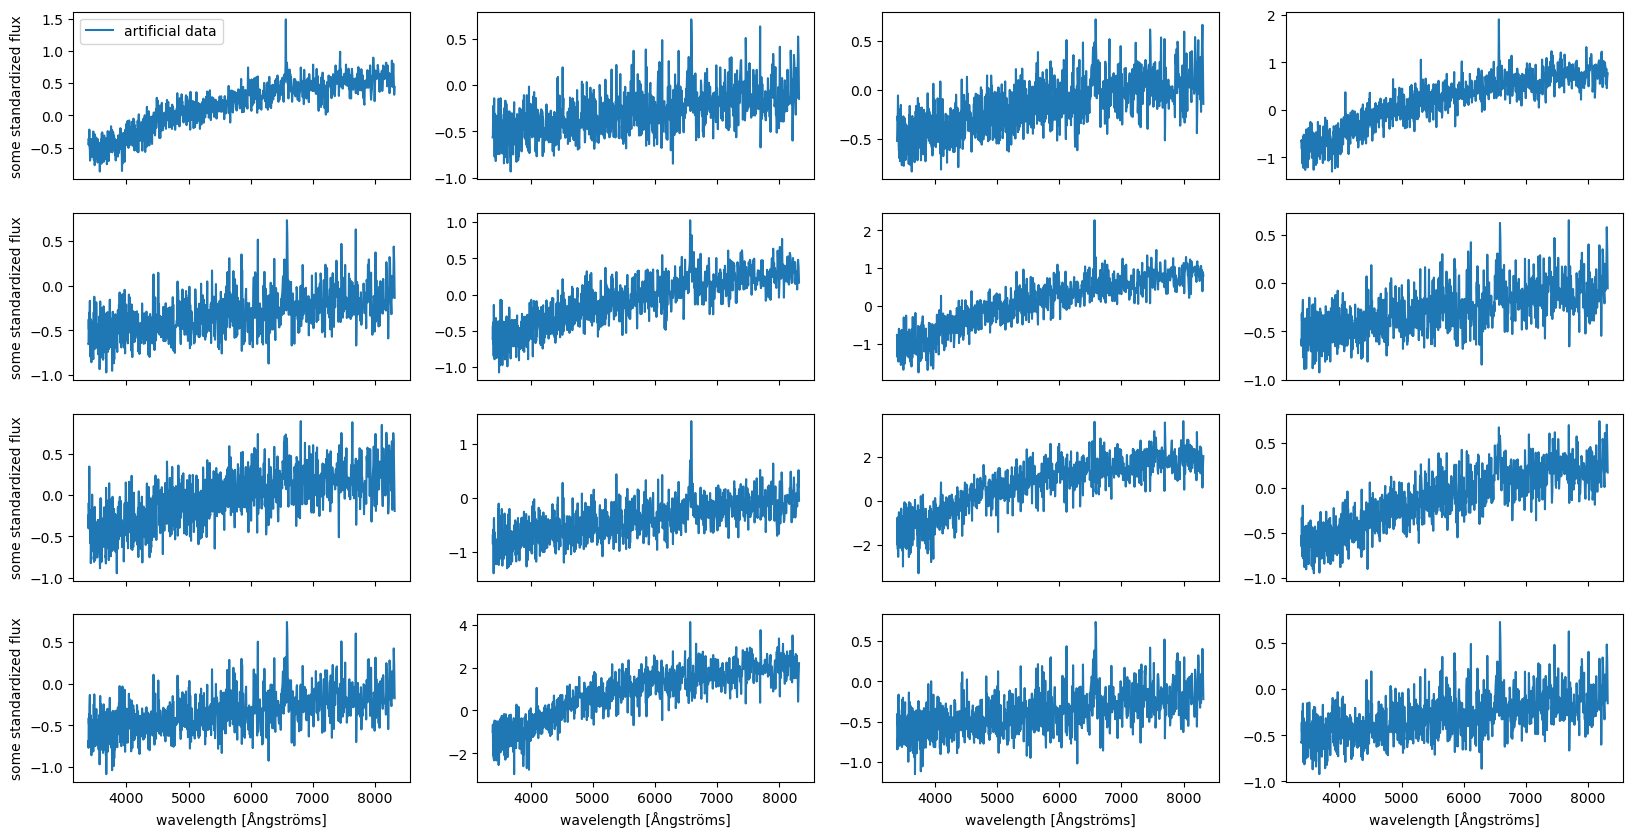

In [27]:
VAE.eval()
with torch.no_grad():
  samples = VAE.prior.sample([16])
  data_samples = VAE.decoder(samples)

# This is the mapping from pixel to the de-redshifted (rest) wavelength
wlmin, wlmax      = (3388,8318)
fixed_num_bins    = 1000
wl_range          = (np.log10(wlmin),np.log10(wlmax))
wl                = np.logspace(wl_range[0],wl_range[1],fixed_num_bins)

fig, ax = plt.subplots(4,4, figsize=(20,10), sharex=True)
ax = ax.flatten()
for ii in range(16):
  ax[ii].plot(wl,data_samples[ii], label='artificial data')
  if ii in np.arange(12,16):
    ax[ii].set_xlabel('wavelength [Ångströms]')
  if ii in [0,4,8,12]:
    ax[ii].set_ylabel('some standardized flux')
  if ii==0:
    ax[ii].legend()
plt.show()